In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [3]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        uniqueModelsToKeep.append(uniqueModels[i])
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [4]:
#uniqueModels = getAllUniqueModels()[-10:]

In [5]:
uniqueModels = getUniqueModelsForTicker("KRE")

***ORIGINAL MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
***UNIQUE MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
25TH PERCENTILE SHARPE -0.6337067875941056
ACTIVITY 0.8881118881118881
ALPHA 0.007988175323716528
ANNUALIZED RETURN -0.011486281434638368
BETA 0.0743272730028087
FACTOR SHARPE 0.5893244467631594
MIN ROLLING SHARPE -1.3928904549409589
OOS_ACTIVITY 0.8809523809523809
OOS_ALPHA 0.09336759044226908
OOS_ANNUALIZED RETURN 0.0924040888470603
OOS_BETA 0.007300853474550487
OOS_FACTOR SHARPE 1.5828331654699737
OOS_RAW BETA 0.11234528721040882
OOS_RELATIVE SHARPE -0.21072972318748795
OOS_RELATIVE SHARPE SLIPPAGE -0.6098572118915898
OOS_SHARPE 1.2492831706585108
OOS_SHARPE DIFFERENCE -0.33354999481146286
OOS_SHARPE DIFFERENCE SLIPPAGE -0.9653022211830575
OOS_SHARPE SLIPPAGE DECAY -0.6317522263715947
OOS_STABILITY 0.7319827336651228
OOS_TOTAL DAYS SEEN 252
OOS_TREYNOR -35.03359140763217
RAW BETA 0.04255704328814437
RELATIVE SHARPE -1.0663703126798745
RELATIVE SHA

In [4]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    aggregateSlippageReturns = None
    cleanedModels = []
    for mod in allModels:
        
        try:
            algoReturn, algoPredictions, algoSlippageAdjustedReturn = dataAck.getModelData(mod)
            print(mod.describe())
            algoReturn.columns = [str(mod.describe())]
            algoPredictions.columns = [str(mod.describe())]
            algoSlippageAdjustedReturn.columns =  [str(mod.describe())]
            if aggregateReturns is None:
                aggregateReturns = algoReturn
                aggregatePredictions = algoPredictions
                aggregateSlippageReturns = algoSlippageAdjustedReturn
            else:
                aggregateReturns = aggregateReturns.join(algoReturn)
                aggregatePredictions = aggregatePredictions.join(algoPredictions)
                aggregateSlippageReturns = aggregateSlippageReturns.join(algoSlippageAdjustedReturn)
            cleanedModels.append(mod)
        except:
            print("SKIPPING", mod.describe())
    return aggregateReturns, aggregatePredictions, aggregateSlippageReturns, cleanedModels

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
            
    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions, modelSlippageReturns, cleanedModels = generateAllReturnsFromCache(uniqueModels)
    
    return cleanedModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [14]:
factorToTrade = "SPY"
uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
KRE
SPY
ATTEMPTING PULL 45a4b200fef0601fa93217a9261b7b1502543d08fad2c9b2f56062ba
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)


TICKER SHARPE 0.267970321767 SHARPE 0.0601033106941 SLIPPAGE SHARPE -0.357057173665
5


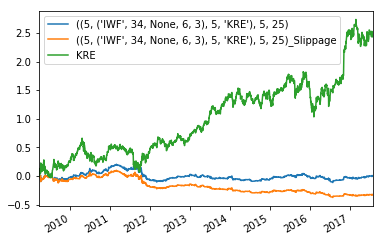

In [21]:
##PERFORM SANITY CHECK
import empyrical
import portfolioGeneration
import matplotlib.pyplot as plt
for i in range(len(modelReturns.columns)):
    item = modelReturns.columns[i]
    slipper = modelSlippageReturns[[modelReturns.columns[i]]]
    slipper.columns = [modelReturns.columns[i] + "_Slippage"]
    tickerReturn = dataAck.getDailyFactorReturn(uniqueModels[i].inputSeries.targetTicker, joinedData)
    tickerReturn.columns = [uniqueModels[i].inputSeries.targetTicker]
    empyrical.cum_returns(modelReturns[[modelReturns.columns[i]]].join(slipper).join(tickerReturn)).plot()
    print("TICKER SHARPE", empyrical.sharpe_ratio(tickerReturn), "SHARPE", empyrical.sharpe_ratio(modelReturns[[modelReturns.columns[i]]]), "SLIPPAGE SHARPE", empyrical.sharpe_ratio(modelSlippageReturns[[modelReturns.columns[i]]])) 
    plt.show()

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",1.000000,0.299586,0.361516,0.080119,0.258076,0.145291,0.203028,0.411027,0.080046,0.510203
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.299586,1.000000,0.192101,0.029264,0.072288,0.047432,0.098660,0.144577,0.019973,0.270357
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.361516,0.192101,1.000000,0.229095,0.382568,0.111080,0.255624,0.458611,0.276160,0.418490
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.080119,0.029264,0.229095,1.000000,0.139398,0.096351,0.107538,0.211629,0.082706,0.077791
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.258076,0.072288,0.382568,0.139398,1.000000,0.138176,0.282684,0.303221,0.545019,0.389455
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.145291,0.047432,0.111080,0.096351,0.138176,1.000000,0.171520,0.223435,0.071180,0.154845
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.203028,0.098660,0.255624,0.107538,0.282684,0.171520,1.000000,0.205648,0.120847,0.323344
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.411027,0.144577,0.458611,0.211629,0.303221,0.223435,0.205648,1.000000,0.101910,0.359140
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.080046,0.019973,0.276160,0.082706,0.545019,0.071180,0.120847,0.101910,1.000000,0.358881
Factor Return,0.510203,0.270357,0.418490,0.077791,0.389455,0.154845,0.323344,0.359140,0.358881,1.000000


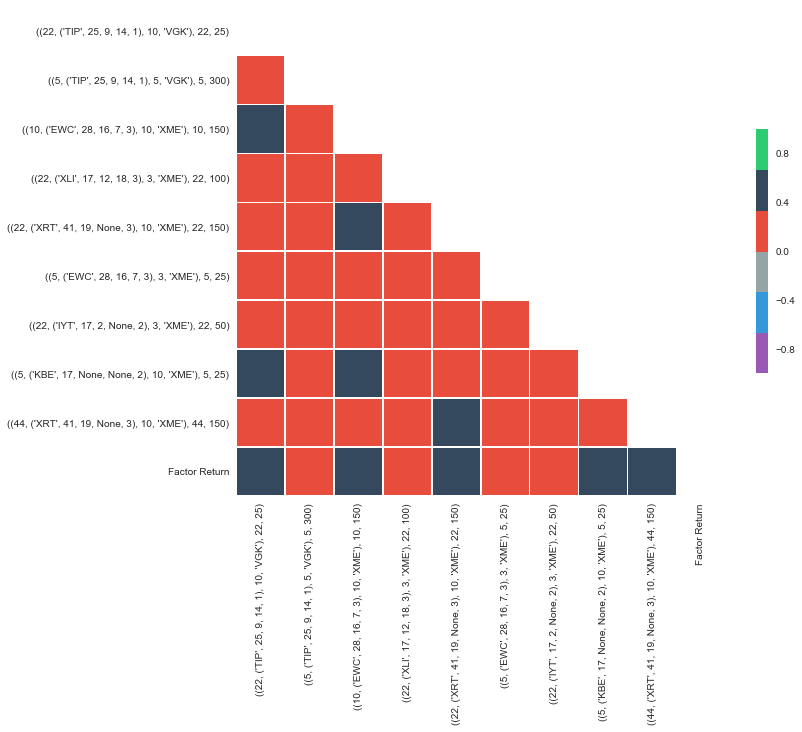

,"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)","((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)","((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)","((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)","((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)","((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)","((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)","((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)","((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",Factor Return
"((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)",0.000054,0.000019,0.000024,0.000010,0.000017,0.000013,0.000019,0.000023,0.000006,0.000036
"((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)",0.000019,0.000070,0.000014,0.000004,0.000006,0.000005,0.000010,0.000009,0.000002,0.000022
"((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)",0.000024,0.000014,0.000080,0.000033,0.000031,0.000013,0.000029,0.000031,0.000025,0.000036
"((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)",0.000010,0.000004,0.000033,0.000263,0.000021,0.000020,0.000022,0.000026,0.000014,0.000012
"((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)",0.000017,0.000006,0.000031,0.000021,0.000083,0.000016,0.000032,0.000021,0.000051,0.000034
"((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)",0.000013,0.000005,0.000013,0.000020,0.000016,0.000158,0.000027,0.000021,0.000009,0.000019
"((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)",0.000019,0.000010,0.000029,0.000022,0.000032,0.000027,0.000156,0.000020,0.000015,0.000039
"((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)",0.000023,0.000009,0.000031,0.000026,0.000021,0.000021,0.000020,0.000058,0.000008,0.000026
"((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)",0.000006,0.000002,0.000025,0.000014,0.000051,0.000009,0.000015,0.000008,0.000105,0.000035
Factor Return,0.000036,0.000022,0.000036,0.000012,0.000034,0.000019,0.000039,0.000026,0.000035,0.000092


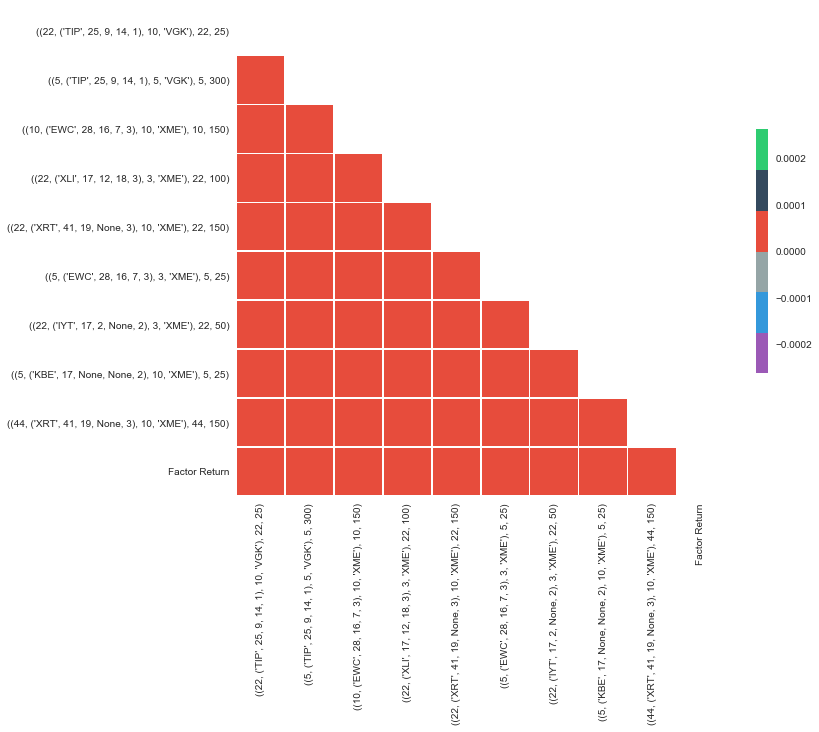

In [10]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [10]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
NEED TO STORE 1981
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)
NEED TO STORE 1981
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
NEED TO STORE 1981
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
NEED TO STORE 1981
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
NEED TO STORE 1981
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
NEED TO STORE 1981
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
NEED TO STORE 1981
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
NEED TO STORE 1981
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
NEED TO STORE 1981


In [11]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="HIGH RELATIVE SHARPE ALLOCATION vs SPY", benchmark=factorToTrade, portfolioType="EW By Ticker")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: 7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e
1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67
43b82397f03341692c8167a264422c295b817c6251490db92125aa0c
5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1
6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0
85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2
8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd
e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c


<Entity('walkforward_portfolio_info', '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e') {'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'portfolioType': 'EW By Ticker', 'benchmark': 'SPY'}>

In [12]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['43b82397f03341692c8167a264422c295b817c6251490db92125aa0c',
 '8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780',
 '8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094',
 'e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c',
 '85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2',
 '6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0',
 '5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1',
 '1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67',
 '9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd']

In [13]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [14]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-05-19,0.012015,NaN,0.012015,-0.000047,0.000392,0.013516,0.012015,NaN,0.001896
2009-05-20,-0.000000,NaN,-0.023192,0.000181,-0.000050,-0.026907,-0.000000,NaN,-0.000325
2009-05-21,-0.000000,NaN,-0.000000,0.000042,0.000514,-0.004303,0.003577,NaN,0.005057
2009-05-22,0.000000,NaN,-0.021902,-0.000428,0.000674,0.026779,-0.043804,NaN,0.015694
2009-05-26,-0.000000,NaN,-0.000000,0.000057,0.000060,-0.002548,0.002071,NaN,-0.015451
2009-05-27,0.000000,NaN,0.000000,-0.000433,-0.000606,0.013689,0.000000,NaN,0.011927
2009-05-28,-0.013426,NaN,0.013426,-0.000734,-0.001599,0.016310,0.013426,NaN,0.017060
2009-05-29,-0.034073,NaN,0.034073,-0.002529,-0.002954,0.040462,0.068146,NaN,0.024398
2009-06-01,-0.002411,NaN,0.000000,-0.000471,-0.001944,0.005575,0.009644,NaN,0.013099
2009-06-02,0.016103,NaN,0.032207,0.004152,0.005528,-0.035729,-0.064413,NaN,-0.032912


In [15]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,-0.043757,-0.000171,0.043757,0.023588,-0.009804,0.002735,0.087513,0.049226,-0.034858
2009-06-22,0.000000,0.000101,-0.012883,-0.007096,0.004597,-0.002013,-0.025766,-0.013285,0.011569
2009-06-23,-0.008931,0.000035,-0.017862,-0.004849,0.001186,-0.002163,-0.017862,-0.008443,0.002148
2009-06-24,-0.046888,0.000092,-0.023444,-0.012271,0.007929,-0.007693,-0.046888,-0.019415,0.012377
2009-06-25,0.008905,-0.000017,-0.000000,0.002261,-0.001526,0.001739,0.004453,0.003200,-0.001756
2009-06-26,-0.001586,0.000000,0.000793,-0.000378,0.008099,-0.000365,0.000000,-0.000465,0.006731
2009-06-29,0.011741,-0.000000,-0.023483,0.005091,-0.007180,0.005962,-0.000000,0.005320,-0.005406
2009-06-30,0.000000,-0.000000,0.000000,-0.000000,0.014288,-0.000000,0.000000,-0.000000,0.007495
2009-07-01,-0.000000,0.000158,-0.000000,0.004855,-0.022157,0.007705,-0.000000,0.002322,-0.007272
2009-07-02,-0.000000,0.000504,-0.000000,0.008172,-0.005583,0.014931,0.025826,0.000807,-0.001734


,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,e01883a35e1a85df844eb09fa09244b1646c01f0f0eb953e1c26413c,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,9ef7410299afb662c4c52426c6315956a2414567a55a337a35caabbd,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780
2009-06-19,0.50,0.001953,-0.5,-0.269531,0.281250,-0.031250,-1.00,-0.562500,1.0000
2009-06-22,0.00,0.003906,-0.5,-0.275391,0.347656,-0.078125,-1.00,-0.515625,0.8750
2009-06-23,-0.50,0.001953,-1.0,-0.271484,0.414062,-0.121094,-1.00,-0.472656,0.7500
2009-06-24,-1.00,0.001953,-0.5,-0.261719,0.480469,-0.164062,-1.00,-0.414062,0.7500
2009-06-25,-1.00,0.001953,0.0,-0.253906,0.542969,-0.195312,-0.50,-0.359375,0.6250
2009-06-26,-1.00,0.000000,0.5,-0.238281,0.601562,-0.230469,0.00,-0.292969,0.5000
2009-06-29,-0.50,0.000000,1.0,-0.216797,0.664062,-0.253906,0.00,-0.226562,0.5000
2009-06-30,0.00,-0.001953,0.5,-0.203125,0.714844,-0.269531,0.50,-0.152344,0.3750
2009-07-01,0.00,-0.005859,0.0,-0.179688,0.761719,-0.285156,0.00,-0.085938,0.2500
2009-07-02,0.00,-0.009766,0.0,-0.158203,0.804688,-0.289062,-0.50,-0.015625,0.2500


In [37]:
cleanedAggregateReturns

,85b8af878af9f1625e0ad42bd132ecc3b6dfc42764f8b8150272eee2,6b1052e31ed14173b646a9d4cfd942d2439d7eaf19634d900785a2a0,8a29d2ff4eb6c69b07b9f895a9fb54ff7c211152a69b284af48bc780,43b82397f03341692c8167a264422c295b817c6251490db92125aa0c,5b02076b09bf6fd98b7328d489e91a40f8269c910f9a099784c7e2a1,1e81d7ab58221a84ab2b5beff8dc4037158733b036d3e61427917b67,8ca0ff9d4dc792576647cb4e9c86784df53f01bf8556535d950bb094
2009-05-19,0.000392,0.012015,0.001896,0.012015,-0.000047,0.013516,0.012015
2009-05-20,-0.000050,-0.000000,-0.000325,-0.000000,0.000181,-0.026907,-0.023192
2009-05-21,0.000514,-0.000000,0.005057,0.003577,0.000042,-0.004303,-0.000000
2009-05-22,0.000674,0.000000,0.015694,-0.043804,-0.000428,0.026779,-0.021902
2009-05-26,0.000060,-0.000000,-0.015451,0.002071,0.000057,-0.002548,-0.000000
2009-05-27,-0.000606,0.000000,0.011927,0.000000,-0.000433,0.013689,0.000000
2009-05-28,-0.001599,-0.013426,0.017060,0.013426,-0.000734,0.016310,0.013426
2009-05-29,-0.002954,-0.034073,0.024398,0.068146,-0.002529,0.040462,0.034073
2009-06-01,-0.001944,-0.002411,0.013099,0.009644,-0.000471,0.005575,0.000000
2009-06-02,0.005528,0.016103,-0.032912,-0.064413,0.004152,-0.035729,0.032207


In [17]:
portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)

[0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006,
 0.07142857142857144,
 0.07142857142857144,
 0.07142857142857144,
 0.25000000000000006]

In [18]:
if portfolioInfo["portfolioType"] == "HRP":
    print("HRP")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            22, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW By Ticker":
    print("EW By Ticker")
    weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
    

EW By Ticker


In [19]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

{'key': '7c76373df7fc8e82ea6e123724190c0f69c0f25e169c139bf3093e6e', 'description': 'HIGH RELATIVE SHARPE ALLOCATION vs SPY', 'benchmark': 'SPY', 'portfolioType': 'EW By Ticker'}
((44, ('XRT', 41, 19, None, 3), 10, 'XME'), 44, 150)
((10, ('EWC', 28, 16, 7, 3), 10, 'XME'), 10, 150)
((5, ('EWC', 28, 16, 7, 3), 3, 'XME'), 5, 25)
((22, ('TIP', 25, 9, 14, 1), 10, 'VGK'), 22, 25)
((22, ('XLI', 17, 12, 18, 3), 3, 'XME'), 22, 100)
((22, ('IYT', 17, 2, None, 2), 3, 'XME'), 22, 50)
((5, ('KBE', 17, None, None, 2), 10, 'XME'), 5, 25)
((22, ('XRT', 41, 19, None, 3), 10, 'XME'), 22, 150)
((5, ('TIP', 25, 9, 14, 1), 5, 'VGK'), 5, 300)


# STORE ALL TICKERS AS OWN MODELS

In [5]:
import importlib
importlib.reload(portfolio)
importlib.reload(portfolioGeneration)

<module 'portfolioGeneration' from '/home/prohb125/walkforwardTrader/portfolioGeneration.py'>

In [ ]:
allModels = portfolio.getModels(returnEntireObject=False)
for model in allModels:
    factorToTrade = model.inputSeries.targetTicker
    portfolioHash = portfolioGeneration.getPortfolioHash([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    if portfolio.getPortfolioByKey(portfolioHash) is not None:
        print("ALREADY SAVED", model.describe())
        continue
    
    portfolioHash = portfolioGeneration.storePortfolio([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    ##TEST TO SEE IF ALREADY EXISTS
    
    uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
        computeReturnsForUniqueModelsCache([model], factorToTrade)
    portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)
    
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    display(portfolioInfo)
    modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
    allModels = portfolio.getModelsByKey(modelHashes)
    aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
    
    cleanedAggregateReturns = aggregateReturns.dropna()
    cleanedAggregatePredictions = aggregatePredictions.dropna()
    if portfolioInfo["portfolioType"] == "HRP":
        print("HRP")
        ##HRP ALLOCATION
        hrpReturns, historicalWeights = portfolioGeneration.\
                produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                22, startIndex=None, maxWindowSize=True)
        print("COMPUTED HISTORICAL WEIGHTS")
        display(historicalWeights)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW":
        print("EW")
        ##EW ALLOCATION
        ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                         None)
        display(ewReturns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW By Ticker":
        print("EW By Ticker")
        weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    portfolioInfo = {
        "key":portfolioInfo.key.name,
        "description":portfolioInfo["description"],
        "benchmark":portfolioInfo["benchmark"],
        "portfolioType":portfolioInfo["portfolioType"],
        "startedTrading":portfolioInfo["startedTrading"]
    }
    print(portfolioInfo)
    portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData, portfolioInfo["startedTrading"])
    portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

PORTFOLIO HASH: f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac
016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
IYR
ATTEMPTING PULL 016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
NEED TO STORE 2252


<Entity('walkforward_portfolio_info', 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'benchmark': 'IYR', 'description': 'Model Alone', 'portfolioType': 'EW'}>

EW


,0
2008-08-11,-1.352006e-06
2008-08-12,-1.968072e-06
2008-08-13,3.038465e-06
2008-08-14,-4.981445e-07
2008-08-15,-7.634072e-06
2008-08-18,-8.828504e-06
2008-08-19,1.287826e-06
2008-08-20,-9.136455e-06
2008-08-21,1.813030e-05
2008-08-22,-2.431116e-05


{'key': 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac', 'description': 'Model Alone', 'benchmark': 'IYR', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
